=== 応答率予測 精度（回帰） ===
RMSE: 0.2333464169040517

=== 提案額予測 精度（回帰） ===
RMSE: 3.598221315832452


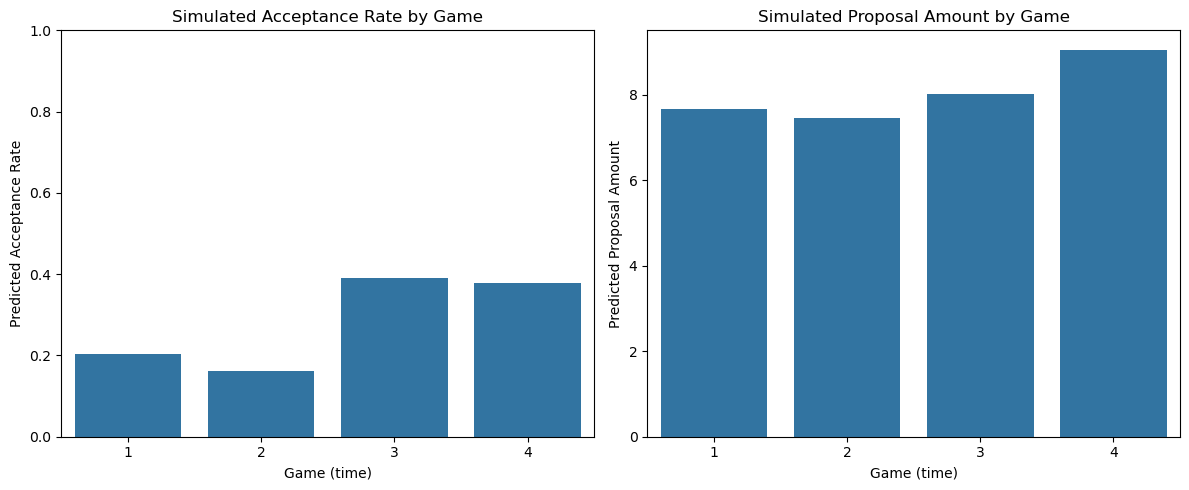


=== 各ゲームの予測平均値 ===
 time  mean_response  mean_proposal
    1       0.203451       7.676700
    2       0.160598       7.467130
    3       0.391225       8.013421
    4       0.377573       9.057052
=== Kruskal-Wallis検定（提案額）===
検定統計量: 19.143951857255182
p値: 0.0002552862421236204

=== Kruskal-Wallis検定（応答率）===
検定統計量: 44.6963521157575
p値: 1.0734855850715375e-09

=== Game 1 のn人分の予測データ ===
    time  predicted_response  predicted_proposal
0      1            0.217461           10.000000
1      1            0.268178            8.356476
2      1            0.398664           10.000000
3      1            0.391356           10.000000
4      1            0.000000            8.069110
5      1            0.000000            8.069160
6      1            0.256748           10.000000
7      1            0.256436           10.000000
8      1            0.256751            7.363888
9      1            1.000000           10.000000
10     1            0.270703            7.382039
11     1            0.4

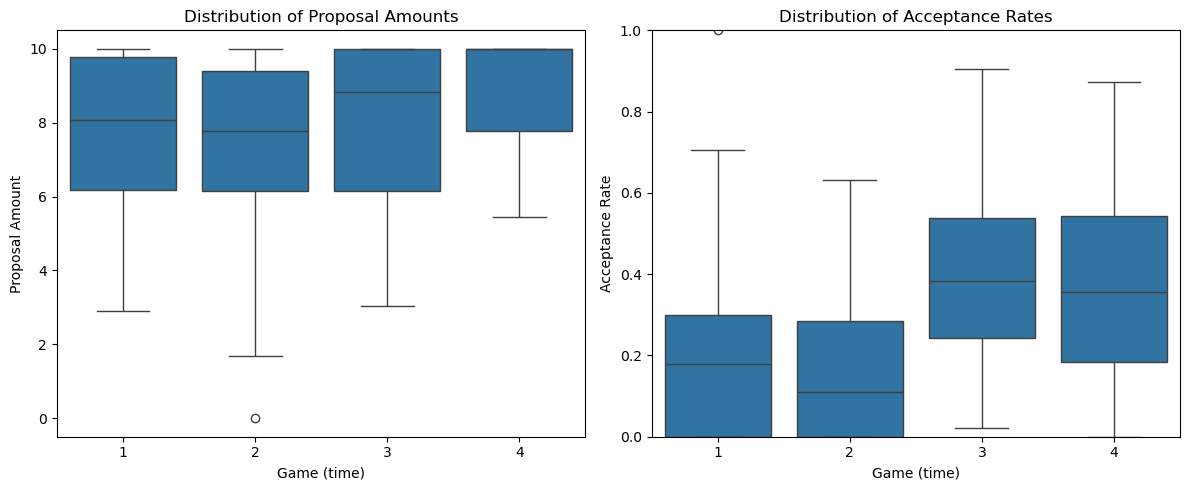

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import kruskal
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

# Excelファイルの読み込み
file_path = "C:\\Users\\jinte\\anaconda3\\envs\\yuki\\06.26再実験データ.xlsx"
sheets = ['ゲーム1', 'ゲーム2', 'ゲーム3', 'ゲーム4']

# timeの割当てを辞書で指定
time_mapping = {
    'ゲーム1': 2,
    'ゲーム2': 1,
    'ゲーム3': 3,
    'ゲーム4': 4
    }

# 各シートからデータ読み込みと加工
df_all = pd.DataFrame()
for sheet in sheets:
    df = pd.read_excel(file_path, sheet_name=sheet)
    df = df.copy()
    df['time'] = time_mapping[sheet]  # 正しいtimeを割り当て
    df_all = pd.concat([df_all, df], ignore_index=True)

# 提案額: proposal（0〜10）、応答: response（0=拒否, 1=受諾）
df_model = df_all[['time', '提案額', '応答率']].dropna()
df_model.columns = ['time', 'proposal', 'response']

# 特徴量と目的変数
X = df_model[['time']]
y_response = df_model['response']  # 応答（回帰）
y_proposal = df_model['proposal']  # 提案額（回帰）

# 学習・検証データに分割（応答）
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_response, test_size=0.2, random_state=42)
# 学習・検証データに分割（提案額）
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y_proposal, test_size=0.2, random_state=42)

# モデル構築（応答：回帰）
reg_response = RandomForestRegressor(random_state=42)
reg_response.fit(X_train_r, y_train_r)

# モデル構築（提案額：回帰）
reg_proposal = RandomForestRegressor(random_state=42)
reg_proposal.fit(X_train_p, y_train_p)

# 応答予測と評価
y_pred_r = reg_response.predict(X_test_r)
print("=== 応答率予測 精度（回帰） ===")
mse = mean_squared_error(y_test_r, y_pred_r)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# 提案額予測と評価
y_pred_p = reg_proposal.predict(X_test_p)
print("\n=== 提案額予測 精度（回帰） ===")
mse = mean_squared_error(y_test_p, y_pred_p)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# --- シミュレーション（各ゲーム50 組） ---
sim_df = pd.DataFrame({'time': [1]*50 + [2]*50 + [3]*50 + [4]*50})

# 予測
sim_df['predicted_response'] = reg_response.predict(sim_df[['time']])
sim_df['predicted_proposal'] = reg_proposal.predict(sim_df[['time']])

# 残差（予測誤差）の標準偏差をノイズの大きさに設定
resid_p = y_test_p - y_pred_p
resid_r = y_test_r - y_pred_r
std_p = resid_p.std()
std_r = resid_r.std()
# ノイズを追加（推定されたばらつきを使用）
sim_df['predicted_proposal'] += np.random.normal(0, std_p, len(sim_df))
sim_df['predicted_proposal'] = sim_df['predicted_proposal'].clip(0, 10)
sim_df['predicted_response'] += np.random.normal(0, std_r, len(sim_df))
sim_df['predicted_response'] = sim_df['predicted_response'].clip(0, 1.0)

# ゲームごとの平均応答率と平均提案額を可視化
summary = sim_df.groupby('time').agg(
    mean_response=('predicted_response', 'mean'),
    mean_proposal=('predicted_proposal', 'mean')
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 棒グラフ（応答率）
sns.barplot(x='time', y='mean_response', data=summary, ax=axes[0])
axes[0].set_title('Simulated Acceptance Rate by Game')
axes[0].set_xlabel('Game (time)')
axes[0].set_ylabel('Predicted Acceptance Rate')
axes[0].set_ylim(0, 1)

# 棒グラフ（提案額）
sns.barplot(x='time', y='mean_proposal', data=summary, ax=axes[1])
axes[1].set_title('Simulated Proposal Amount by Game')
axes[1].set_xlabel('Game (time)')
axes[1].set_ylabel('Predicted Proposal Amount')

plt.tight_layout()
plt.savefig("機械学習グラフ.png", dpi=300, bbox_inches='tight')
plt.show()

# 表の出力（グラフの後に）
print("\n=== 各ゲームの予測平均値 ===")
print(summary.to_string(index=False))

# 提案額の検定
groups_proposal = [sim_df[sim_df['time'] == t]['predicted_proposal'] for t in range(1, 5)]
stat_p, pval_p = kruskal(*groups_proposal)

print("=== Kruskal-Wallis検定（提案額）===")
print("検定統計量:", stat_p)
print("p値:", pval_p)

# 応答率の検定
groups_response = [sim_df[sim_df['time'] == t]['predicted_response'] for t in range(1, 5)]
stat_r, pval_r = kruskal(*groups_response)

print("\n=== Kruskal-Wallis検定（応答率）===")
print("検定統計量:", stat_r)
print("p値:", pval_r)

# 各ゲームn人分のデータ表示
for t in range(1, 5):
    print(f"\n=== Game {t} のn人分の予測データ ===")
    print(sim_df[sim_df['time'] == t].reset_index(drop=True))

sim_df.to_csv("シミュレーション予測.csv", index=False)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='time', y='predicted_proposal', data=sim_df)
plt.title('Distribution of Proposal Amounts')
plt.xlabel('Game (time)')
plt.ylabel('Proposal Amount')

plt.subplot(1, 2, 2)
sns.boxplot(x='time', y='predicted_response', data=sim_df)
plt.title('Distribution of Acceptance Rates')
plt.xlabel('Game (time)')
plt.ylabel('Acceptance Rate')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("クラスカルウォリス検定.png", dpi=300, bbox_inches='tight')
plt.show()